In [292]:
import os
import mlflow
import numpy as np
import pandas as pd

from math import sqrt
from joblib import delayed
from joblib import Parallel

from warnings import catch_warnings
from warnings import filterwarnings
from multiprocessing import cpu_count
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.dates as mdates

from pathlib import Path
from functools import reduce
from datetime import datetime

from prophet import Prophet

import random
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from regressors import stats
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


## Load data

In [293]:
df = pd.read_csv('./../../error_dfs/error_2018_2019_VAR.csv', converters={'ags2': str, 'ags5': str} )
df

,date,ground_truth,pred,ags5
0,2018-01-01,9.3,9.100280,01001
1,2018-02-01,9.2,9.081553,01001
2,2018-03-01,9.1,8.925309,01001
3,2018-04-01,8.8,8.987270,01001
4,2018-05-01,8.3,8.770163,01001
...,...,...,...,...
9619,2019-08-01,7.0,6.928729,16077
9620,2019-09-01,6.5,6.595042,16077
9621,2019-10-01,6.5,6.526319,16077
9622,2019-11-01,6.3,6.483260,16077


In [294]:
# fix ags5 missing 0 
df['ags5'] = np.where(df.ags5.str.len() ==4, '0' + df['ags5'], df['ags5'])
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [295]:
# add 'ags2','bundesland','kreis'
df2 = pd.read_csv('./../../corona_data_sets/oeffentliche_finanzen.csv', converters={'ags2': str, 'ags5': str} )
df = pd.merge(df, df2[['ags2','ags5','bundesland','kreis']])


In [296]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [297]:
df['error'] = df.apply(lambda x: mean_absolute_percentage_error(x['ground_truth'], x['pred']), axis=1)

In [1]:
df['date'][:-3]

NameError: name 'df' is not defined

In [299]:
#df.to_csv('./MAPE_errors_2018_2019.csv', index = False)

## Plot each variable

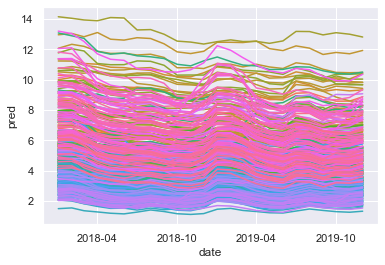

In [300]:
g = sns.lineplot(data=df, x="date", y="pred",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

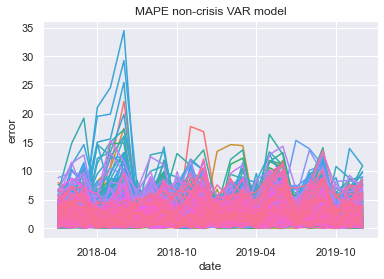

In [357]:
g = sns.lineplot(data=df, x="date", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()
g.set_title('MAPE non-crisis VAR model')
plt.savefig('MAPE_VAR_normal.png')

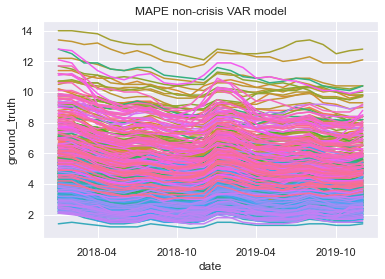

In [356]:
g = sns.lineplot(data=df, x="date", y="ground_truth",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()
g.set_title('MAPE non-crisis VAR model')
plt.savefig('MAPE_VAR_normal.png')

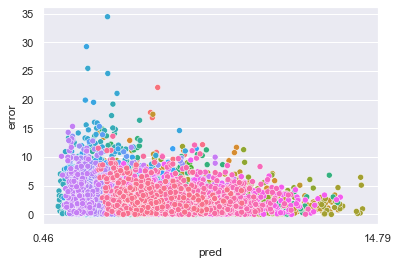

In [303]:
g = sns.scatterplot(data=df, x="pred", y="error",  hue="ags5")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.legend_.remove()

## Plot sample to compare prediction to ground truth

In [304]:
df_long = df.melt(id_vars=['date','ags5','ags2','bundesland','kreis'], var_name='y_type', value_name='vals')

In [305]:
df_long = df_long[df_long['y_type'].isin(['ground_truth','pred'])]

In [306]:
random.seed(31415)
sample_args = random.sample(list(set(df_long['ags5'])), 30)
df_sample = df_long[df_long['ags5'].isin(sample_args)]

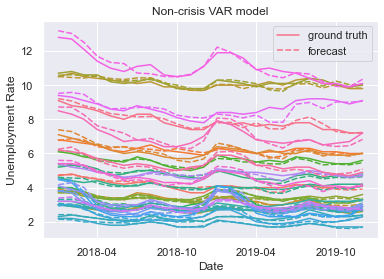

In [307]:
g = sns.lineplot(data=df_sample, x="date", y="vals",  hue="ags5", style="y_type")
g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
g.set(xlabel='Date', ylabel='Unemployment Rate')
g.set_title('Non-crisis VAR model')
plt.legend(loc='upper right', labels=['ground truth', 'forecast'])
plt.savefig('sample_ur_VAR_normal.png')

## Look into mean errors

In [308]:
df_mean_error = df.groupby(['ags5','ags2','bundesland','kreis']).mean()
df_mean_error              

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
01001,01,Schleswig-Holstein,"Flensburg, Stadt",8.137500,8.067004,3.221706
01002,01,Schleswig-Holstein,"Kiel, Landeshauptstadt",7.883333,7.943206,2.054605
01003,01,Schleswig-Holstein,"Lübeck, Hansestadt",7.525000,7.506519,2.038060
01004,01,Schleswig-Holstein,"Neumünster, Stadt",8.125000,8.089037,1.757839
01051,01,Schleswig-Holstein,Dithmarschen,5.887500,5.977891,2.889511
...,...,...,...,...,...,...
16073,16,Thüringen,Saalfeld-Rudolstadt,5.375000,5.351936,2.572121
16074,16,Thüringen,Saale-Holzland-Kreis,4.329167,4.329224,3.245052
16075,16,Thüringen,Saale-Orla-Kreis,4.733333,4.757153,3.215742


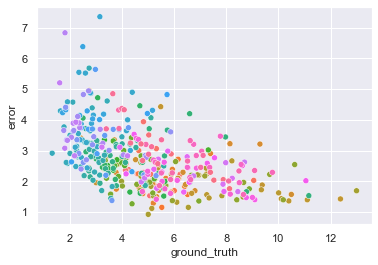

In [309]:
g = sns.scatterplot(data=df_mean_error, x="ground_truth", y="error",  hue="ags5")
g.legend_.remove()

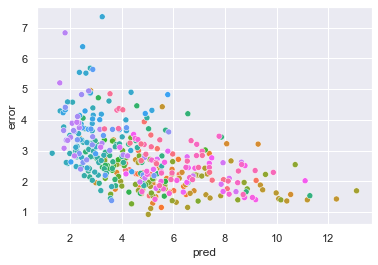

In [310]:
g = sns.scatterplot(data=df_mean_error, x="pred", y="error",  hue="ags5")
g.legend_.remove()

In [311]:
df_mean_error.sort_values(by = ['error'], ascending=False)

,,,,ground_truth,pred,error
ags5,ags2,bundesland,kreis,,,
09276,09,Freistaat Bayern,Regen,3.154167,3.252799,7.354732
09773,09,Freistaat Bayern,Dillingen a.d.Donau,1.816667,1.815872,6.830677
09372,09,Freistaat Bayern,Cham,2.500000,2.496244,6.380346
08437,08,Baden-Württemberg,Sigmaringen,2.741667,2.789759,5.681942
09476,09,Freistaat Bayern,Kronach,2.983333,2.889236,5.640615
...,...,...,...,...,...,...
06432,06,Hessen,Darmstadt-Dieburg,4.387500,4.387263,1.267181
05358,05,Nordrhein-Westfalen,Düren,6.545833,6.557037,1.152277
03159,03,Niedersachsen,Göttingen,5.529167,5.538900,1.151366


<AxesSubplot:xlabel='error', ylabel='Density'>

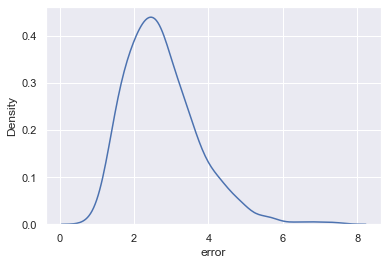

In [312]:
sns.kdeplot(data=df_mean_error, x="error", common_norm=False)

## Look into errors

In [313]:
df.sort_values(by = ['error'], ascending=False)

,date,ground_truth,pred,ags5,ags2,bundesland,kreis,error
6077,2018-06-01,2.4,3.226777,09276,09,Freistaat Bayern,Regen,34.449025
6269,2018-06-01,1.8,2.326327,09372,09,Freistaat Bayern,Cham,29.240414
5981,2018-06-01,1.9,2.383714,09272,09,Freistaat Bayern,Freyung-Grafenau,25.458624
6076,2018-05-01,2.6,3.238524,09276,09,Freistaat Bayern,Regen,24.558605
149,2018-06-01,4.4,5.373608,01054,01,Schleswig-Holstein,Nordfriesland,22.127443
...,...,...,...,...,...,...,...,...
2917,2019-02-01,4.5,4.500086,06432,06,Hessen,Darmstadt-Dieburg,0.001906
9303,2019-04-01,6.7,6.700065,16064,16,Thüringen,Unstrut-Hainich-Kreis,0.000963
2183,2019-12-01,12.8,12.800099,05513,05,Nordrhein-Westfalen,Gelsenkirchen,0.000775
3978,2019-07-01,5.9,5.900022,07318,07,Rheinland-Pfalz,Stadt Speyer,0.000373


In [314]:
df['diff_ground_truth'] = df.groupby('ags5')['ground_truth'].diff(1) 
df['diff_ground_truth_abs'] = df['diff_ground_truth'].abs()

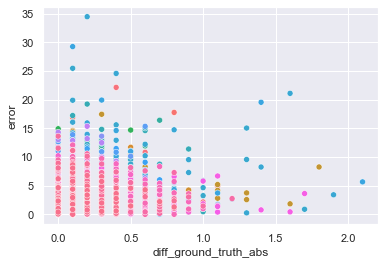

In [315]:
g = sns.scatterplot(data=df, x="diff_ground_truth_abs", y="error",  hue="ags5")
g.legend_.remove()

<AxesSubplot:xlabel='error', ylabel='Density'>

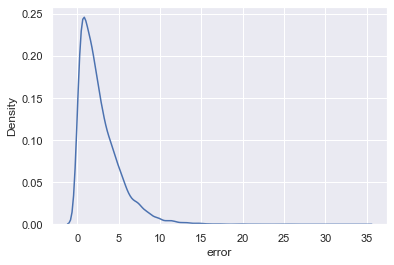

In [316]:
sns.kdeplot(data=df, x="error", common_norm=False)

<AxesSubplot:xlabel='error', ylabel='Density'>

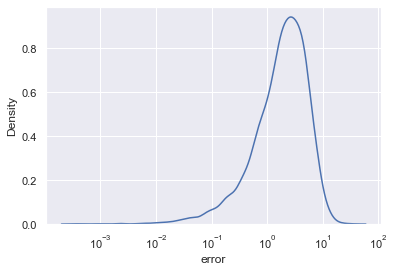

In [317]:
sns.kdeplot(data=df, x="error", common_norm=False,log_scale=True)

# Load structural data

In [318]:
df_structural = pd.read_csv('./../../final_dfs/for_modeling/df_final_stationery.csv', converters={'ags2': str, 'ags5': str} )

df_structural["urban_/_rural"] = np.where(df_structural["urban_/_rural"]==1, 'urban', 'rural')
df_structural['eligible_area'] = np.where(df_structural['eligible_area']==1, 'eligible_area', 'not_eligible_area')
df_structural['east_west'] = np.where(df_structural['east_west']==1, 'west', 'east')
df_structural = df_structural.rename(columns={'urban_/_rural': 'urban_rural'})
df_structural

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
0,0,"Flensburg, Stadt",01001,01,92,500,35,240,2901,240,...,2,4,3,rural,99,99,west,1,C,eligible_area
1,2,"Kiel, Landeshauptstadt",01002,01,92,460,37,268,2037,265,...,2,1,2,urban,99,99,west,0,C/D,eligible_area
2,2,"Lübeck, Hansestadt",01003,01,90,532,37,297,1927,294,...,1,1,2,urban,5,99,west,0,C/D,eligible_area
3,0,"Neumünster, Stadt",01004,01,85,588,37,316,1648,313,...,2,3,2,rural,5,99,west,0,D,eligible_area
4,0,Dithmarschen,01051,01,51,1864,35,448,3517,443,...,4,4,3,rural,5,99,west,0,C,eligible_area
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,0,Saalfeld-Rudolstadt,16073,16,62,1423,37,341,2492,322,...,3,4,2,rural,99,99,east,0,C*,eligible_area
397,0,Saale-Holzland-Kreis,16074,16,54,1677,38,343,3419,340,...,3,3,2,rural,99,99,east,0,C*,eligible_area
398,0,Saale-Orla-Kreis,16075,16,54,1686,35,449,3172,444,...,3,4,2,rural,99,99,east,2,C*,eligible_area
399,0,Greiz,16076,16,55,1654,38,608,2779,563,...,3,2,2,urban,99,99,east,0,C*,eligible_area


In [319]:
df_structural[df_structural['kreis'] == 'Stuttgart']

,cluster,kreis,ags5,ags2,supermarkets_population,supermarkets_average_distance,public_transport_availability,average_distance_bus_stop,average_distance_train_station,average_distance_public_transport,...,room_type_location,district_settlement_structure,type_of_settlement_structure,urban_rural,metropolitan_region,metropolitan_area,east_west,border_proximity,support_area_status,eligible_area
178,2,Stuttgart,08111,08,96,403,68,302,1442,265,...,1,1,1,urban,9,5,west,0,N,not_eligible_area


### Merge to df with mean errors

In [320]:
df_mixed = pd.merge(df_mean_error, df_structural, on = ['ags5','ags2'])
list(df_mixed.columns)

['ags5',
 'ags2',
 'ground_truth',
 'pred',
 'error',
 'cluster',
 'kreis',
 'supermarkets_population',
 'supermarkets_average_distance',
 'public_transport_availability',
 'average_distance_bus_stop',
 'average_distance_train_station',
 'average_distance_public_transport',
 'Unnamed:_0',
 'number_of_students',
 'number_of_hospitals',
 'number_of_hospital_beds',
 'number_of_hospital_beds_adj',
 'hospital_patiants',
 'households_of_1_person',
 'households_of_2_person',
 'households_of_3_person',
 'households_of_4_person',
 'households_of_5_person_or_more',
 'household_with_kids',
 'household_with_kids_under_3',
 'household_with_kids_over_3_under_6',
 'household_with_kids_over_6_under_10',
 'household_with_kids_over_10_under_15',
 'household_with_kids_over_15_under_18',
 'household_with_double_income_no_kids',
 'car_density',
 'no_of_paths_per_person_and_day',
 'kilometers_per_person_and_day',
 '_percentage_out_of_home',
 'share_of_journeys_on_foot',
 'share_of_journeys_on_bike',
 'propo

### Compare error in two_groups

In [321]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    p = sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    p.set_title('MAPE non-crisis VAR model')
    plt.savefig(f'{column_name}_MAPE_non_crisis.png')
    plt.show()
    df[column_name] = df[column_name].astype(str)
    one, two = list(set(df[column_name]))
    df_one = df[df[column_name]==one]
    df_two = df[df[column_name]==two]
    return ttest_ind(df_one['error'], df_two['error'], equal_var=False)

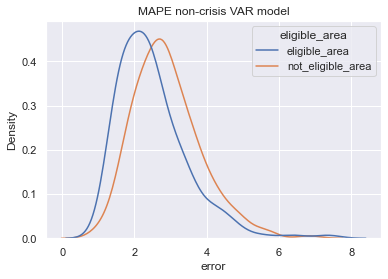

Ttest_indResult(statistic=-4.138184800353696, pvalue=4.3774359761277136e-05)

In [322]:
compare_error_in_two_groups(df_mixed, 'eligible_area')

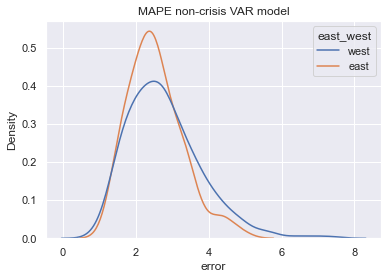

Ttest_indResult(statistic=-2.3514225006182787, pvalue=0.019988252049599094)

In [323]:
compare_error_in_two_groups(df_mixed, 'east_west')

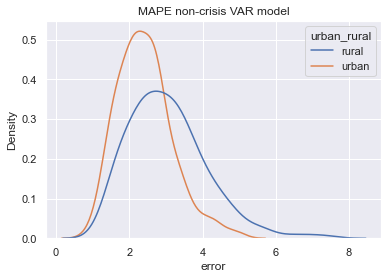

Ttest_indResult(statistic=6.827246166994047, pvalue=3.66432228994386e-11)

In [324]:
compare_error_in_two_groups(df_mixed, 'urban_rural')

### Compare compare error in multiple groups

In [325]:
#function to do that cor a spesific column 
def compare_error_in_two_groups(df, column_name): 
    sns.kdeplot(data=df, x="error", hue=column_name,  common_norm=False)
    plt.show()
    mod = ols(f'error ~ {column_name}',
                data=df).fit()
                
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

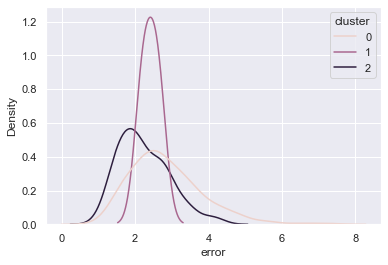

              sum_sq     df          F    PR(>F)
cluster    20.391281    1.0  22.809713  0.000003
Residual  356.695458  399.0        NaN       NaN


In [326]:
compare_error_in_two_groups(df_mixed, "cluster")

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


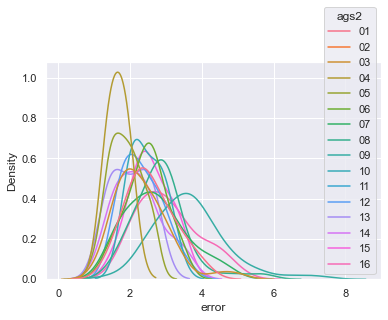

              sum_sq     df          F        PR(>F)
ags2      146.627207   15.0  16.330119  6.643709e-33
Residual  230.459532  385.0        NaN           NaN


In [327]:
compare_error_in_two_groups(df_mixed, "ags2")

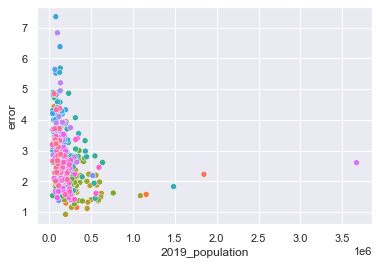

In [328]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

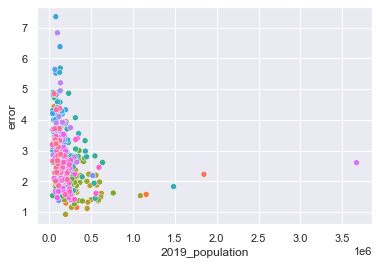

In [329]:
g = sns.scatterplot(data=df_mixed, x="2019_population", y="error",  hue="ags5")
g.legend_.remove()

### Linear Regression

In [330]:
df_mixed.set_index('ags5', drop=True, inplace=True)

In [331]:
df_mixed['east_west'] = df_mixed['east_west'].astype(str)
df_mixed['eligible_area'] = df_mixed['eligible_area'].astype(str)
df_mixed['cluster'] = df_mixed['cluster'].astype(str)
df_mixed['urban_rural'] = df_mixed['urban_rural'].astype(str)

X = df_mixed.drop(['kreis','pred','error','ground_truth','Unnamed:_0'], axis=1)
Y = np.log(df_mixed['error'])

X = pd.get_dummies(data=X, drop_first=True)

In [332]:
regr = LinearRegression()
regr.fit(X, Y, sample_weight=None)

LinearRegression()

In [333]:
stats.summary(regr, X, Y, X.columns)

Residuals:
    Min      1Q  Median     3Q    Max
-0.5569 -0.0992 -0.0021 0.1023 0.5866


Coefficients:
                                                    Estimate                  Std. Error          t value   p value
_intercept                                       -177.503886  3.681762e+03+8.755656e+04j  -0.0001+0.0020j  0.998385
supermarkets_population                             0.002030  2.030000e-03+8.264000e-03j   0.0569-0.2316j  0.811609
supermarkets_average_distance                       0.000172  2.430500e-02+1.034300e-02j   0.0060-0.0026j  0.994794
public_transport_availability                       0.006642  1.263900e-02+2.330000e-03j   0.5082-0.0937j  0.605590
average_distance_bus_stop                          -0.000199  2.980000e-04+1.300000e-05j  -0.6679+0.0302j  0.504159
average_distance_train_station                      0.000020  1.400000e-05+0.000000e+00j   1.4005-0.0019j  0.162128
average_distance_public_transport                   0.000319 -3.150000e-04-6.000000e-

### Sequential Feature Selector

In [334]:
sfs1 = sfs(regr, k_features = 10,forward=True, floating=False, scoring='r2', cv=5)
sfs1.fit(X, Y)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=10,
                          scoring='r2')

In [335]:
summary_table_select = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
summary_table_select

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(177,)","[-0.19137723846487242, -0.08372059732465709, -...",-0.136815,"(ags2_09,)",0.149104,0.116008,0.058004
2,"(124, 177)","[0.01251626254156979, -0.00114855641900391, -0...",0.004224,"(Residential_area_percentage, ags2_09)",0.123448,0.096047,0.048023
3,"(124, 173, 177)","[0.06511268201840992, 0.15163441191656235, -0....",0.054149,"(Residential_area_percentage, ags2_05, ags2_09)",0.090236,0.070206,0.035103
4,"(74, 124, 173, 177)","[0.10644401382881707, 0.18561596229564226, 0.0...",0.100623,"(Commute_within_50km, Residential_area_percent...",0.073659,0.057309,0.028655
5,"(69, 74, 124, 173, 177)","[0.1774651041673564, 0.2464252297225189, 0.046...",0.13692,"(Number_of_Commuters_on_place_of_residence), C...",0.088255,0.068665,0.034333
6,"(69, 74, 124, 147, 173, 177)","[0.17173710424591337, 0.23482705372603385, 0.0...",0.157799,"(Number_of_Commuters_on_place_of_residence), C...",0.069237,0.053868,0.026934
7,"(25, 69, 74, 124, 147, 173, 177)","[0.19343520623391308, 0.2381970530804256, 0.10...",0.173082,"(kilometers_per_person_and_day, Number_of_Comm...",0.056345,0.043838,0.021919
8,"(25, 65, 69, 74, 124, 147, 173, 177)","[0.21296370496211192, 0.22093978024107075, 0.0...",0.183672,"(kilometers_per_person_and_day, no_of_foreigne...",0.063703,0.049563,0.024781
9,"(25, 65, 69, 74, 114, 124, 147, 173, 177)","[0.2634759310729935, 0.17791974719231152, 0.14...",0.195375,"(kilometers_per_person_and_day, no_of_foreigne...",0.061483,0.047836,0.023918
10,"(25, 65, 69, 74, 114, 124, 147, 159, 173, 177)","[0.2926274951727781, 0.18525321887709545, 0.14...",0.213851,"(kilometers_per_person_and_day, no_of_foreigne...",0.095953,0.074655,0.037327


In [336]:
list(summary_table_select['feature_names'])[:5]

[('ags2_09',),
 ('Residential_area_percentage', 'ags2_09'),
 ('Residential_area_percentage', 'ags2_05', 'ags2_09'),
 ('Commute_within_50km', 'Residential_area_percentage', 'ags2_05', 'ags2_09'),
 ('Number_of_Commuters_on_place_of_residence)',
  'Commute_within_50km',
  'Residential_area_percentage',
  'ags2_05',
  'ags2_09')]

### Ridge

In [337]:
rr = Ridge(alpha=0.5) 
rr.fit(X, Y)

/Users/amitsasson/venv/DSSGx/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95493e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.5)

In [338]:
stats.summary(rr, X, Y, X.columns)

Residuals:
    Min     1Q  Median     3Q    Max
-0.5736 -0.102 -0.0071 0.1079 0.6214


Coefficients:
                                                   Estimate                  Std. Error         t value   p value
_intercept                                       -15.764340  3.767763e+03+8.960176e+04j -0.0000+0.0002j  0.999860
supermarkets_population                            0.001412 -2.325800e-02+2.200000e-05j -0.0607-0.0001j  0.951634
supermarkets_average_distance                      0.000148  2.813000e-02+4.000000e-06j  0.0053-0.0000j  0.995802
public_transport_availability                      0.004516  2.043000e-02+8.000000e-06j  0.2210-0.0001j  0.825166
average_distance_bus_stop                         -0.000197  1.410000e-04+4.000000e-06j -1.4002+0.0424j  0.162028
average_distance_train_station                     0.000021  7.800000e-05-0.000000e+00j  0.2671+0.0014j  0.789515
average_distance_public_transport                  0.000271  4.780000e-04-9.400000e-05j  0.5464+0.107

household_with_kids  
public_transport_per_1000_inhabitants 
number_of_companies_repair_motor_vehicles 
number_of_companies_hospitality
number_of_companies_technical_services
debtor_quota
purchasing_power_per_household

## Look at the variables that are important for predicting the error

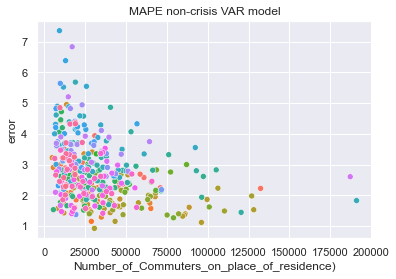

In [339]:
g = sns.scatterplot(data=df_mixed, x="Number_of_Commuters_on_place_of_residence)", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
plt.savefig('Commuters_MAPE.png')

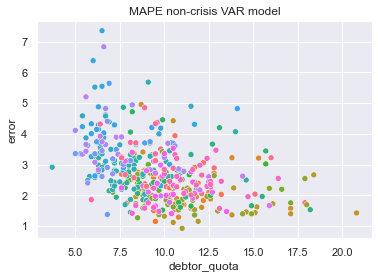

In [340]:
g = sns.scatterplot(data=df_mixed, x="debtor_quota", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
plt.savefig('debtor_quota_MAPE.png')

<AxesSubplot:xlabel='debtor_quota', ylabel='Density'>

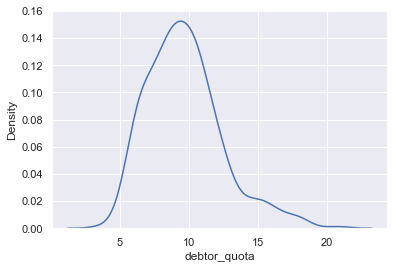

In [341]:
sns.kdeplot(data=df_mixed, x="debtor_quota", common_norm=False)

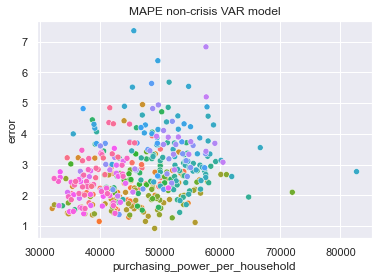

In [342]:
g = sns.scatterplot(data=df_mixed, x="purchasing_power_per_household", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
plt.savefig('purchasing_power_MAPE.png')

<AxesSubplot:xlabel='purchasing_power_per_household', ylabel='Density'>

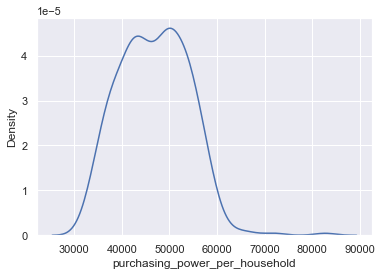

In [343]:
sns.kdeplot(data=df_mixed, x="purchasing_power_per_household", common_norm=False)

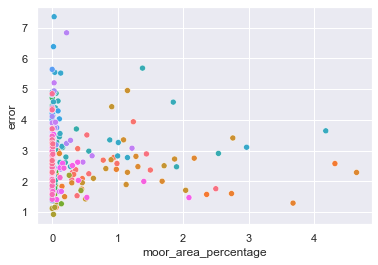

In [344]:
g = sns.scatterplot(data=df_mixed, x="moor_area_percentage", y="error",  hue="ags5")
g.legend_.remove()

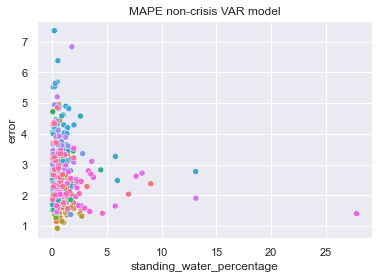

In [345]:
g = sns.scatterplot(data=df_mixed, x="standing_water_percentage", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
plt.savefig('standing_water_percentage_MAPE_non_crisis.png')

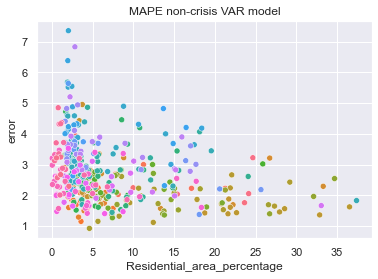

In [352]:
g = sns.scatterplot(data=df_mixed, x="Residential_area_percentage", y="error",  hue="ags5")
g.set_title('MAPE non-crisis VAR model')
g.legend_.remove()
plt.savefig('Residential_area_percentage_MAPE_non_crisis.png')

In [350]:
df_mixed['ags2_09'] =  np.where(df_mixed['ags2']=='09', 'Bayren', 'not Bayren')

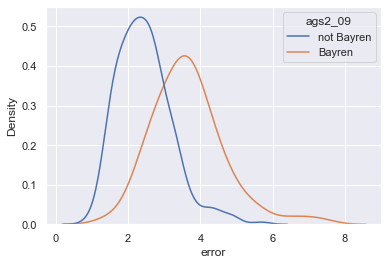

              sum_sq     df           F        PR(>F)
ags2_09   106.535515    1.0  157.115055  1.278472e-30
Residual  270.551224  399.0         NaN           NaN


In [353]:
compare_error_in_two_groups(df_mixed, 'ags2_09')

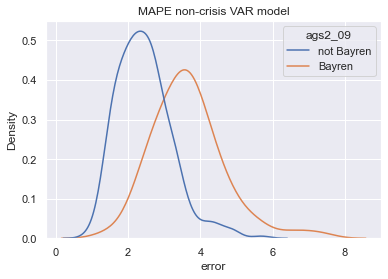

In [354]:
    p = sns.kdeplot(data=df_mixed, x="error", hue='ags2_09',  common_norm=False)
    p.set_title('MAPE non-crisis VAR model')
    plt.savefig(f'Bayren_MAPE_non_crisis.png')
    plt.show()